# Project YODA

In [31]:
!pip install git+https://github.com/steiningerjakob/Project-YODA

  Cloning https://github.com/steiningerjakob/Project-YODA to /tmp/pip-req-build-sw5cw_e2
  Running command git clone --filter=blob:none -q https://github.com/steiningerjakob/Project-YODA /tmp/pip-req-build-sw5cw_e2
  Resolved https://github.com/steiningerjakob/Project-YODA to commit 53e813d8d0882b67b8503395b2d47ec8bd3471d1
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tensorflow.keras (from projectyoda) (from versions: none)
ERROR: No matching distribution found for tensorflow.keras


In [32]:
### standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from PIL import Image as PImage
### deep learning imports

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import utils

In [33]:
BUCKET_NAME = 'wagon-data-745-project-yoda'
BUCKET_DATA_PATH = 'raw_data'

In [34]:
def get_dataframes_from_gcp(optimize=False, **kwargs):
    """method to get the training data from google cloud bucket"""
    base_path = f"gs://{BUCKET_NAME}/{BUCKET_DATA_PATH}"
    index = pd.read_csv(f'{base_path}/index.csv')
    metadata = pd.read_csv(f'{base_path}/metadata.csv')
    df = pd.merge(index, metadata, on='class_id')

    # put all but 2 images of each class in training set, rest in validation set
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])
    for i in range(1,len(df['class_id'].value_counts())+1):
        df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])
        df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

    return df_train, df_valid

In [35]:
#df_train, df_valid = get_dataframes_from_gcp()

In [36]:
#print(df_train.shape)
#print(df_valid.shape)

## Data exploration

### Import data

In [37]:
index = pd.read_csv('../raw_data/index.csv')
index.head()

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1


In [38]:
metadata = pd.read_csv('../raw_data/metadata.csv')
metadata.head()

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


In [39]:
df = pd.merge(index, metadata, on='class_id')
df.head()

,path,class_id,lego_ids,lego_names,minifigure_name
0,marvel/0001/001.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,marvel/0001/002.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,marvel/0001/003.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
3,marvel/0001/004.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
4,marvel/0001/005.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


In [40]:
len(df)

361

### Explore files

In [41]:
df.minifigure_name.value_counts()

SPIDER-MAN                     18
TRACKER TRAQUEUR RASTREADOR    12
OWEN GRADY                     12
YODA                           12
LUKE SKYWALKER                 12
R2-D2                          12
GENERAL GRIEVOUS               12
HARRY POTTER                   11
TASKMASTER                     11
YELENA BELOVA                  11
RON WEASLEY                    11
BLACK WIDOW                    11
MACE WINDU                     11
GHOST SPIDER                   10
IRON MAN MK 1                  10
EMPEROR PALPATINE              10
IRON MAN MK 50                 10
VENOM                          10
IRON MAN MK 41                 10
CAPTAIN AMERICA                10
OUTRIDER 1                     10
OUTRIDER 2                     10
IRON MAN MK 5                  10
AUNT MAY                       10
ANAKIN SKYWALKER                9
DARTH VADER                     9
OBI-WAN KENOBI                  9
KYLO REN                        8
JANNAH                          8
HAN SOLO      

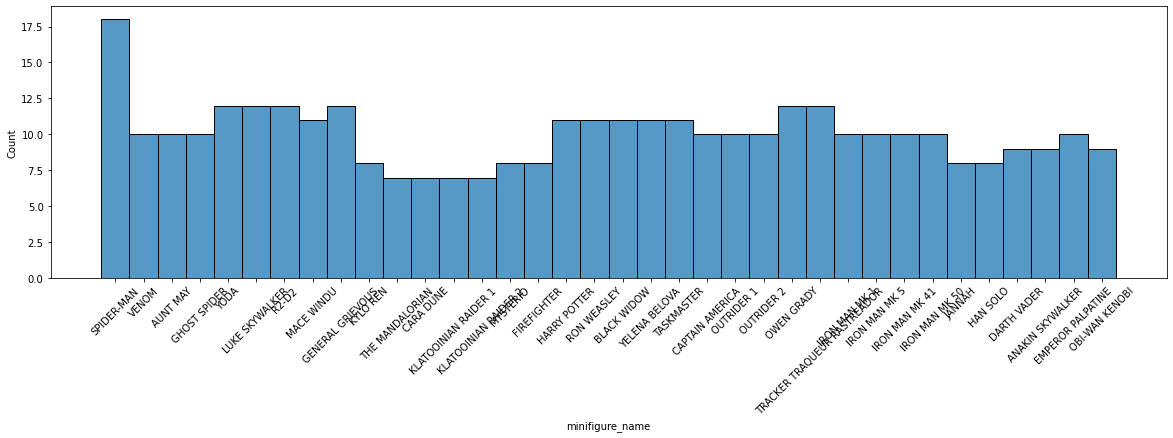

In [42]:
plt.figure(figsize=(20,5))
sns.histplot(df['minifigure_name'])
plt.xticks(rotation=45)
plt.show();

In [43]:
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])

for i in range(1,len(df['class_id'].value_counts())+1):
    df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])    
    df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

In [44]:
df_valid.shape

(74, 5)

In [45]:
root_dir = "../raw_data/"

In [46]:
def loadImages(root_dir, df):
    

    loadedImages = []
    for image in df['path']:
        img = PImage.open(root_dir + image)
        loadedImages.append(img)
    

    return loadedImages


# your images in an array
imgs = loadImages(root_dir, df)


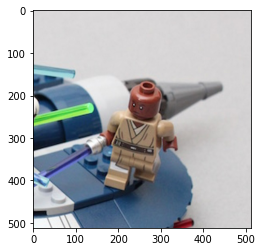

In [47]:
import matplotlib.pyplot as plt
plt.imshow(imgs[80])

### Preprocess data (if necessary)

In [48]:
len(df.minifigure_name.unique())

36

In [49]:
#https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range = 30,
                                       width_shift_range = 0.3,
                                       height_shift_range = 0.3,
                                       brightness_range=[0.2,1.0],
                                       shear_range = 0.3,
                                       zoom_range = 0.4,
                                       fill_mode='nearest',
                                       vertical_flip=True,
                                       horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=root_dir,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=(512, 512),
        batch_size=16)
valid_generator = test_datagen.flow_from_dataframe(
        dataframe=df_valid,
        directory=root_dir,
        x_col="path",
        y_col="minifigure_name",
        class_mode="categorical",
        target_size=(512, 512),
        batch_size=16,
        shuffle=False)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(512,512,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

model.compile(optimizers.Adam(lr=0.001),
loss="categorical_crossentropy", metrics=["accuracy"])






Found 287 validated image filenames belonging to 36 classes.
Found 74 validated image filenames belonging to 36 classes.


2021-11-25 15:05:22.095190: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 260112384 exceeds 10% of free system memory.
2021-11-25 15:05:22.584799: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 260112384 exceeds 10% of free system memory.
2021-11-25 15:05:22.842055: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 260112384 exceeds 10% of free system memory.
/home/hiczer/.pyenv/versions/3.8.12/envs/Project-YODA/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 activation (Activation)     (None, 512, 512, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 510, 510, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 510, 510, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 255, 255, 32)      0         
                                                        

In [21]:
es = callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)

model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    callbacks=[es],
                    verbose=1,
                    epochs=10)

### ...

## Classification model

### Define initial model architecture 

### Train initial model